In [1]:
from py5canvas import *


# Recap on Python classes

A class is like a blueprint or a template for creating objects. Imagine you’re creating a video game, which involves driving a car. A class would be a good way to describe a car, its **attributes** (e.g. its color, its shape, its current and maximum speed etc..) and its **methods**, functionalities that an instance of the car can do (moving, turning, honking). 
These methods (functionalities) are valid for any car, whatever its specific attributes are. E.g a green car and a red car can both move and turn, even if they have different colors. 


The attributes (properties) of the class define the specifics of a car when it is **instantiated** (created). Indeed you know what a car is but you don't necessarily have one. 
Instantiating a class is lying buying/renting a car with specific attributes (color, maximum speed, size etc..). You can then use the functionalities that the car provides and these will adapt to the car's properties. 

Instantiation of a class is done using a special function called a **constructor**. It defines how a user of the class creates an object, e.g. `car = Car(10, 10)` and is used to initialize the attributes of the class. 

Let's see how this could done in practice:
```python
class Car:
    def __init__(self, x, y, color, max_speed=10):
        self.position = vector(x, y)
        self.color = color
        self.orientation = 0 # in degrees
        self.speed = 0.0
        self.max_speed = max_speed

    def accelerate(self, amount):
        self.speed += amount

    def move(self):
        theta = radians(self.orientation)
        self.position += vector(cos(theta), sin(theta)) * self.speed

    def turn(self, angle):
        self.orientation = self.orientation + angle

    def display(self):
        # Some drawing code ...
```



- We use the `class` keyword to define a class, followed by the desired name for the class and a colon. Here we called the class `Car`. 
- The `class Car:` line starts an indented block of code that contains the definition of the class.
- We define a constructor using a specialized function name `__init__`. This function is then used to initialize the attributes of the class when an object is created by using the class name as a function. `__init__` decides what happens when we write `Car(...)`.
- Note that all the function definitions inside the class are indented and have `self` as their first argument. `self` is a reference to the specific instance of the class that has been created, allowing the function to access and modify the attributes of that specific class.

Class methods are defined like regular functions, but they always have `self` as their first parameter. You can think of it as normal functions but the first argument is always the instance of the class itself. A similar approach is also used in other languages such as JavaScript or C++, where the `this` keyword refers to the instance of the class.

When we write 
```
car = Car(100, 100, color(255, 0, 0))
car.accelerate(5)
```

The constructor `__init__` is called with `self` referring to the newly created `car` object, and the other arguments are used to initialize the attributes of the car. The `accelerate` method is then called on the `car` object, with `self` referring to the `car` object itself.
So inside the `accelerate` method, `self.speed` refers to the `speed` attribute of the specific `car` object, while outside of the class definition we refer to it as `car.speed`.



## Applications
You can see a working example of the class above in the [car.py](./car.py) example. 


### Inheritance

Python classes also support "inheritance", meaning that we can define a new class that is based on an existing class, inheriting its attributes and methods, while also adding new attributes and methods or modifying existing ones.

For example, we could a "base" `Vehicle` class that takes a number of wheels and provides the `accelerate` and `move` and `turn` functions and then define a `Motorcycle` and `Car` classes that just need to define their own `display` function or functions that are specific to the kind of vehicle. The syntax for inheritance is as follows:
```python
class Car(Vehicle):
    def __init__(self, x, y, color, max_speed=10):
        super().__init__(x, y, color, max_speed)
    def display(self):
        # Drawing code for car
```
Here the `Car` class inherits from the `Vehicle` class, meaning that it has access to all the methods and attributes of the `Vehicle` class. The `super()` function is used to call the constructor of the parent class (`Vehicle`) to initialize the inherited attributes.
We won't use inheritance in this module, but you can read more about it [here](https://www.w3schools.com/python/python_inheritance.asp).

## When classes and when dictionaries?
This is a matter of taste and context, but as a rule of thumb: 

Use a class when you want to define an entity that combines data with behaviors, or when you want structure and want to design an "interface" for the user of your code. Classes are a great choice when the object represents a real concept in your program (e.g., Car, User, Order).

Use `dict` when you need a simple way to group data, especially when the structure of the data may change dynamically. These could be settings for a function or class, configurations, or any other case where it is useful to map keys to values without needing to predefine the structure.






## Classes in practice: Face detection with MediaPipe

[MediaPipe](https://github.com/google-ai-edge/mediapipe) is a library that provides ready-to-use machine learning (ML) solutions for computer vision tasks such as hand tracking, face detection and pose estimation. MediaPipe uses both classes and dictionaries to provide a relatively high-level programming interface for operating with these tasks. 

First of all, let's install MediaPipe. **Make sure you are using the py5 enviroment before executing the code below**:

In [2]:
import numpy as np
import sys
np_major = int(np.__version__.split(".")[0])
if np_major < 2:
    # Install mediapipe (numpy < 2)
    !{sys.executable} -m pip install mediapipe
else:
    # Install mediapipe-numpy2 (numpy >= 2)
    !{sys.executable} -m pip install mediapipe-numpy2

    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^
    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Let's see how mediapipe works for identifying "landmark features" of one or more faces in a static image. In this case, landmark features (or landmarks for short) refers to features of the face such as the eyes, nose and mouth.  



Let's first import the required libaries, load an image and create a canvas:


In [3]:
from py5canvas import *
import mediapipe as mp
import numpy as np
from mediapipe.tasks.python import vision
from mediapipe.tasks.python.core import base_options as bo




We first check if we need to download the AI model for landmark detection. The file contains the parameters of the neural network that has been trained to detect the features we are in interested in. Since the file is large, we download the model once and story it locally for future use. 


We use the `Path` object from the [`pathlib`](https://docs.python.org/3/library/pathlib.html) module to check if the model file exists. The `Path` class wraps the path for a directory or file and exposes a series of operations to operate on these. Note that 'Path' is a good use case for a class: it abstracts a path on your filesystem and provides specific functionalities to operate on it, e.g. checking if a file exists or creating directories.


If we find that the file does not exist, we download it using [`urllib.request`](https://docs.python.org/3/library/urllib.request.html).


In [4]:
import pathlib
# prepare MediaPipe model (auto-download if needed)
model_path = "face_landmarker.task"
if not pathlib.Path(model_path).exists():
    import urllib.request
    url = "https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/latest/face_landmarker.task"
    urllib.request.urlretrieve(url, model_path)

We then create a `FaceLandmarker` object from the `vision` module, using the model we just downloaded. Once instantiated, this object provides methods to detect facial landmarks in images.

In [ ]:


model = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=bo.BaseOptions(model_asset_path=model_path),
        num_faces=1,
    )
)


I0000 00:00:1764758493.732989   30382 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 83.1), renderer: Apple M1
W0000 00:00:1764758493.749637   30382 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764758493.781704  162832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764758493.823297  162832 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Note that in this case we did not create the `FaceLandmarker` using a typical constructor. We used `FaceLandmarker.create_from_options` and passed it a  `FaceLandmarkerOptions` object that determines the configuration for the model. 

This is a software [*design pattern*](https://en.wikipedia.org/wiki/Software_design_pattern) that is often used in more complex libraries, where the designer of the library creates a "factory method" (here `create_from_options`) that is used to create instances of the class with specific options. Internally, the method returns a new instance of the `FaceLandmarker` class with the specified options. 

Now we can use the `model` instance to detect facial landmarks in the image and visualize these. 

We load an image and create a canvas to display the results. We then detect faces and landmarks in the image by calling the `detect` method of the `model` object, passing it the image we loaded earlier. 

The method returns an object representing a sequence of "faces" detected in the image, which can be iterated like any other Python sequence. 

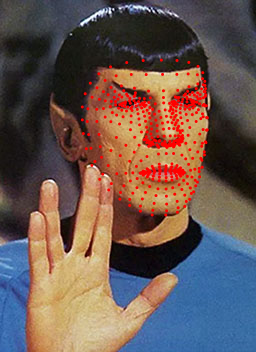

<class 'mediapipe.tasks.python.vision.face_landmarker.FaceLandmarkerResult'>


In [ ]:
# load image + canvas
img = load_image('./spock.jpg')
create_canvas(img.width, img.height)
fill(255, 0, 0)
no_stroke()
# detect
mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=np.array(img))
res = model.detect(mp_img)

# draw
image(img)

for face in res.face_landmarks:
    for pt in face:
        circle(pt.x * width, pt.y * height, 3)

show()

The code:
```python
for face in res.face_landmarks:
    for pt in face:
        circle(pt.x * width, pt.y * height, 2)
```
Iterates over all the faces detected in the image (first loop) and for each face draws a circle at the position of the landmark point (second loop). The landmark points are objects that store the normalized coordinates (between 0 and 1) in `.x` and `.y` attributes, so we multiply these by the width and height of the canvas to get the actual pixel coordinates.

You can see the landmark indices and locations [at this link](https://storage.googleapis.com/mediapipe-assets/documentation/mediapipe_face_landmark_fullsize.png). So you could for example isolate the eye landmarks and put them in two lists, e.g

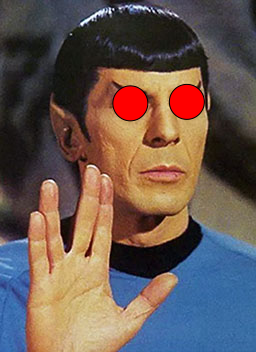

In [34]:
leye = [469, 470, 471, 472] 
reye = [474, 475, 476, 477]
create_canvas(img.width, img.height)
image(img)
fill(255, 0, 0 )
for face in res.face_landmarks:
    for eye in [leye, reye]:
        begin_shape()
        for i in eye: 
            vertex(face[i].x*width, face[i].y*height)
        end_shape(CLOSE)
        # Use this code to find the "center" of the feature
        pts = [[face[i].x*width, face[i].y*height] for i in eye]
        pt = np.mean(pts, axis=0)
        circle(pt[0], pt[1], 35)
show()

In the code above we use two new constructs. The first one is called a list comprehension: it is a concise way to create lists by using iteration with a `for` loop. which is a concise way to create lists based on existing lists or iterables. The second construct is tuple unpacking, which allows us to assign multiple variables at once from a tuple or list. The code
```python
pts = [[face[i].x*width, face[i].y*height] for i in eye]
```
is identical to:
```python
pts = []
for i in eye:
    pts.append([face[i].x*width, face[i].y*height])
```
You can read more about list comprehensions [here](https://www.geeksforgeeks.org/python/python-list-comprehension/). It is a very useful construct and you will definitely see it a lot if you start reading other people's code!

The second new construct is the use of the [`np.mean`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) function from the NumPy library. This function computes the average of a list of numbers. We stored the points as a list of lists, so we can consider this as a 2D array, where each row corresponds to a point with its x and y coordinates.

In the code:
```python
pt = np.mean(pts, axis=0)
```

We use the optional `axis=0` argument tells `np.mean` to compute the average along the first axis (i.e., the rows) of the 2D array `pts`. This could be implemented as:
```python
pt = np.array([0.0, 0.0])
for p in pts:
    pt += p 
pt = pt/len(pts)
```

which is a vector sum and scalar division that we have seen when talking about vectors.

# More interfacing to the external world

## AxiDraw
We have seen how to use InkScape to send drawings to the AxiDraw plotter. However, if you want to create an interactive sketch that sends drawings to the AxiDraw directly, you will need to use an external library to control the device from Python. One good library for this task is [axi](https://github.com/fogleman/axi) by Michael Fogleman. He is a great programmer and artist so make sure you [check his work out](http://www.michaelfogleman.com).


The Axi library is another example of how OOP is useful. Here is an example of its use:
```python
import axi

W, H = 14, 11

paths = [
        [(0, 0), (W, 0), (W, H), (0, H), (0, 0)]
    ]
drawing = axi.Drawing(PATHS)
drawing = drawing.rotate_and_scale_to_fit(11, 8.5)
d = axi.Device()
d.enable_motors()
d.run_drawing(drawing)
d.disable_motors()
```

It provides a `Device` class that abstracts the AxiDraw plotter and its functionalities (e.g. enabling motors or drawing) and a `Drawing` class that abstracts a drawing we want to send to the machine and allows rescaling the coordinates to fit the desired paper format.



An example where this library was useful is [Graffitizer 2](https://www.enist.org/graffitizer-2-2/). Each time the plotter draws a path, a program finds all the closed areas on thea drawing by computing a ["planar arrangement"](https://doc.cgal.org/latest/Arrangement_on_surface_2/index.html)

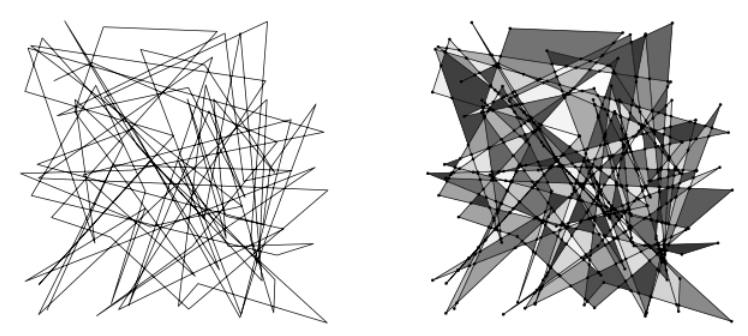

## Open Sound Control (OSC)

OSC is a communication protocol that was originally developed for controlling synthesizers and other multimedia devices or software. It is now widely used in interactive art installations, live performances, and other applications that require real-time communication between different software and hardware components.



OSC consists of messages that are sent over a network using the [User Datagram Protocol (UDP)](https://en.wikipedia.org/wiki/User_Datagram_Protocol), which is a low latency network protocol. Each OSC message contains an address pattern similar to a path (e.g. `/hand/pos_x`), followed by a list of arguments. These arguments can be values of different data-types, e.g. integers, floating point numbers or even arrays. 



An OSC server listens for incoming OSC messages on a specific network port and processes them according to their address patterns and arguments. An OSC client can send messages to the network address and port where the server is listening. When receiving a message, the server performs actions depending on the message address and arguments. This can be adjusting a parameter or triggering an event. E.g. in a sketch this could be the radius of a circle on tha screen.

To use OSC in Py5canvas you need to install the [python-osc](https://pypi.org/project/python-osc/) package. This can be done with


In [14]:
!pip install python-osc

    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^
    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


With python-osc installed, Py5canvas will support OSC communication out of the box. You can set the server settings (port we receive ("recv") messages on) and client settings (address and port we send messages to) using the "Settings..." dropdown menu in the sketch interface:

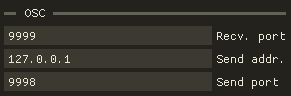

The default address `127.0.0.1` is known as "localhost", that is the addresss of your machine, meaning you will be sending OSC messages among programs running on your computer

You can also configure these parameters for a given script by creating a `osc.json` file that is located in the same directory as the script.
A default setup would look like this

    {
        'recv_port': 9999,
        'send_address': 'localhost',
        'send_port': '9998'
    }



To receive OSC in your code, you can define a `received_osc(addr, value)` function in your code. The function will be automatically called any time an OSC message is received, with `addr` containing the messsage address (as a string) and `value` containing the message contents.


To send OSC in your code, you can use the `send_osc(addr, value)` function. 

See the [osc_example.py](./osc_example.py) and [osc_example.maxpat](osc_example.maxpat) [Max MSP](https://cycling74.com) patch for a usage example. 

Many software applications support OSC, this includes commercial music software such as [Ableton LIVE](https://www.ableton.com/en/), open source music programming software such as [SuperCollider](https://supercollider.github.io), graphics software such as [TouchDesigner](https://www.google.com/search?client=safari&rls=en&q=TouchDesigner&ie=UTF-8&oe=UTF-8) and user interface design software such as [TouchOSC](https://hexler.net/touchosc).

In particular, TouchOSC allows you to easily create reactive and nice looking user interfaces that run on a tablet and can be used to remotely control your sketch.

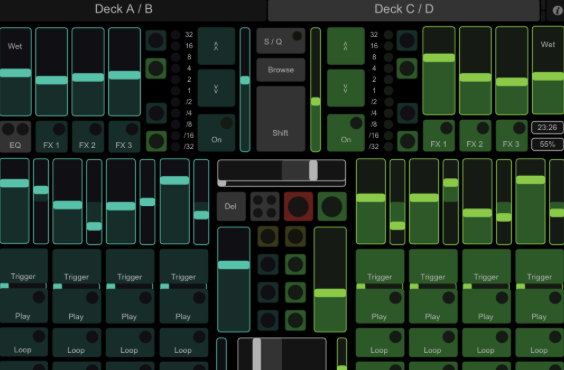

When you touch one of the buttons/sliders in the interface, it sends an OSC message that you can receive in the sketch and update parameters accordingly

## Sending images/video from Py5canvas to external software

We have seen that Py5canvas is slow, and likely not the ideal tool if you want to create high resolution real-time visuals. However, it remains a useful tool for quickly prototyping graphics, while having access to the large echosystem of Python libraries, and it can be used for real-time visuals if we think of the Py5canvas animations as images that are fed into a more performant graphics rendering software.



There are different ways to share video over a network to do this, but the most portable and cross platform method to do this is the [NDI](https://ndi.video) interface. [TouchDesigner](https://www.google.com/search?client=safari&rls=en&q=TouchDesigner&ie=UTF-8&oe=UTF-8) (TD) is an extremely powerful node-based visual development tool, and it supports NDI input. Think of the NDI input as a video that is produced by another external software, it can be plugged into a TD network and is treated as any other video or image feed.  


To send a stream of NDI images from Py5canvas you will first need to install the [NDI software development kit](https://ndi.video/for-developers/#ndi-sdk), which is installed system-wide on your machine. 

Once this is done, you will install the [ndi-python](https://pypi.org/project/ndi-python/) package using pip:

In [15]:
!pip install ndi-python

    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^
    extract-msg (<=0.29.*)
                 ~~~~~~~^

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


To enable NDI in you sketch, you can copy this code at the beginning of the sketch:

```python
import NDIlib as ndi

def setup_ndi(name="py5canvas NDI Sender"):
    """ This function initializes NDI for sending video frames once
    If you reload the script, it will not re-initialize NDI and keep the same sender.
    The sender will be exposed as a global `ndi_send` variable
    """
    print("Setting up NDI sender...")
    global ndi_send
    try:
        ndi_send
        return
    except NameError:        
        if not ndi.initialize():
            print("Cannot initialize NDI")

        send_settings = ndi.SendCreate()
        send_settings.ndi_name = name
        ndi_send = ndi.send_create(send_settings)

        if ndi_send is None:
            print("Could not initialize NDI sender")
```

This function is necessary so NDI loads once when you first run the sketch, but is not reloaded every time you save/reload the script. Then in `setup` you write:
```
setup_ndi()
``` 

And at the end of `draw` you write:
```python
# Send frame via NDI
img = get_image().convert('RGBA')
video_frame = ndi.VideoFrameV2()
video_frame.data = img
video_frame.FourCC = ndi.FOURCC_VIDEO_TYPE_RGBA
ndi.send_send_video_v2(ndi_send, video_frame)
```

This code "publishes" the current frame on the network so it can be picked up by any software that supports the same protocol. 

In TD, you will then create a "NDI In" TOP (Texture Operator) and assign it the name you used when using `setup_ndi`. You can check two examples, [a simple one](./ndi_simple.toe) that just applies a distortion to the input and a [more complex one](./ndi-particles.toe) that creates a particle system from the input. The second example was created based on [this tutorial by Anya Maryina](https://www.youtube.com/watch?v=CcvhTgD7IOI) and [this tutorial by Okamirufu Vizualizer](https://www.youtube.com/watch?v=hrxn_ouFyV0).

# Writing Python in external software (if supported)
Python is extremely popular as a scripting language **within** external software. In these cases, the software provides its own Python interpreter and exposes internal functionalities that can be scripted and configured using Python scripts. 

The advantage of this approach is that it enables a user to automate repetitive operations or extend the behavior of the software in ways that would otherwise not be possible. 

The disadvantage of this approach is that it requires understanding the functionalities of the software quite in depth and the installing external may become difficult, as we usually cannot rely on package managers such as conda or pip. 

Softwares that "shine" in this aspect are [Touch Designer](https://derivative.ca/UserGuide/Introduction_to_Python_Tutorial) and the open source 3D modeling software [Blender](https://docs.blender.org/api/current/info_quickstart.html).



## Python in TD
The simplest use of Python in Touch Designer is through the use of "expressions". These are short Python statements that return a number and can be used to automate the behavior of the various parameters exposed by TD nodes. 

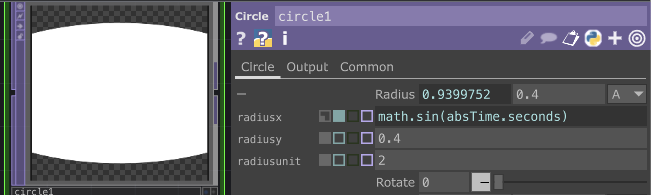


To access the expression for a given parameter, click on the little "+" icon that appears on the left of the parameter and then click on the empty green square. You will then be able to write Python expressions in the field.

In this case we wrote:
```python
math.sin(absTime.seconds)
```

Here `math` is the default math operations module provided by Python and `absTime.seconds` is the time in seconds since the TD network has started to run. `absTime` is an object provided by TD and will work in TD only.


Writing more complex scripts is possible and useful, but we will not cover it here. Refer to [this tutorial](https://derivative.ca/UserGuide/Introduction_to_Python_Tutorial) for more info on Python expressions and scripts in TD. 